# Table of Contents
* [Description](#Description)
* [Import Python](#Import-Python)
* [Import Normalized Images](#Import-Normalized-Images)
* [Select Profile Region(s)](#Select-Profile-Region%28s%29)
* [Export Configuration](#Export-Configuration)


# Description

In this notebook, you will be able to select the profile regions. Then the next notebook will take those region to capture the position of the "wave" vs time

# Import Python

In [1]:
verbose = False
debugging = False
ipts_group = 'IPTS_17099'

import custom_style
custom_style.style()

try:
    from PyQt4.QtGui import QFileDialog
    from PyQt4 import QtCore, QtGui
except ImportError:
    from PyQt5.QtWidgets import QFileDialog
    from PyQt5 import QtCore, QtGui
    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

from ipywidgets.widgets import interact
from ipywidgets import widgets
from IPython.core.display import display, HTML

from pprint import pprint
import pyfits

import datetime
import os
import glob
import shutil
import re

from plotly.offline import plot, init_notebook_mode, iplot
init_notebook_mode()
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

from IPython.display import display
from IPython import display as display_ipython

import config_handler
import file_handler
import utilities
import gui_widgets
import time_utility

display(HTML('<span style="font-size: 20px; color:blue">EXPLANATION: we are importing all \
        the python libraries</span>\
        <br><br><span style="font-size: 20px; color:blue"><b>Make sure you wait until a cell\
        is done executing before running another cell!</span>'))

In [2]:
%gui qt

# Import Normalized Images

In [3]:
display(HTML('<span style="font-size: 20px; color:blue">EXPLANATION: select the folder that contains\
the data you normalized in step2!</span>'))

data_folder = config_handler.load_config(key='output_folder',
                                        default_value = '/Volumes/my_book_thunderbolt_duo/IPTS/IPTS_17099/',
                                        group=ipts_group)
new_data_folder = gui_widgets.gui_dname(dir=data_folder,
                                   message='Select the Data Folder ...')
if new_data_folder:
    config_handler.save_config(key='data_folder', value=new_data_folder, group=ipts_group)
    list_of_data_files = glob.glob(new_data_folder + '/*.tiff')

In [4]:
display(HTML('<span style="font-size: 20px; color:blue">EXPLANATION: we are now loading the normalized data!</span>'))

w = widgets.IntProgress()
w.max = len(list_of_data_files)
display(w)

data_array = []
for _index, _file in enumerate(list_of_data_files):
    _image = file_handler.load_data(_file)
    data_array.append(_image)
    w.value = _index + 1

# Select Profile Region(s) 

You will have the option to select how many sub-region you want to have in the ROI [0, ....n]


In [5]:
display(HTML('<span style="font-size: 20px; color:blue">EXPLANATION: in case you already ran this notebook, \
the program will retrieve the last profile you selected, otherwise you will start with some default \
values, and prepare the algorithm that will isolate the profile regions you defined!</span>'))

[height, width] = np.shape(data_array[0])
_dict = config_handler.load_config(key='profile_roi', group=ipts_group)
if _dict == '':
    _dict = {}
    _dict['x_left'] = 0
    _dict['y_top'] = 0
    _dict['width'] = width
    _dict['height'] = height
    _dict['number_sub_region'] = 1
    
def get_array_of_profiles(data=[],number_sub_region = 1, x_left = 0, y_top = 1, width = width, height = height):
    
    height_bin_size = np.int(height/number_sub_region)
    profile_array = []
    height_bins = []
    
    _from_y = y_top
    _to_y = y_top + height_bin_size + 1
    height_bins.append([_from_y, _to_y])
    
    for _sub_region in range(number_sub_region):
        _range_data = np.mean(data[_from_y:_to_y, x_left:x_left+width], axis=0)
        profile_array.append(_range_data)
        
        _from_y = _to_y 
        _to_y += height_bin_size + 1
        height_bins.append([_from_y, _to_y])
    
    return {'data':profile_array, 'bins':height_bins[:-1]}

display(HTML('<span style="font-size: 20px; color:blue">In the next cell, you will be able to \
select the profile regions by defining the <b>left</b>, <b>top</b>, <b>width</b>, <b>height</b> of \
the global region and <b>how many sub-region</b>\
 you want to have inside. Each sub-region will produce its own profile. <br><br>\
 - The left plot shows a preview of the regions selected.<br>\
 - the right plot shows the profiles of each of the sub-regions</span>'))

{'height': 286, 'number_sub_region': 5, 'width': 50, 'x_left': 40, 'y_top': 47}

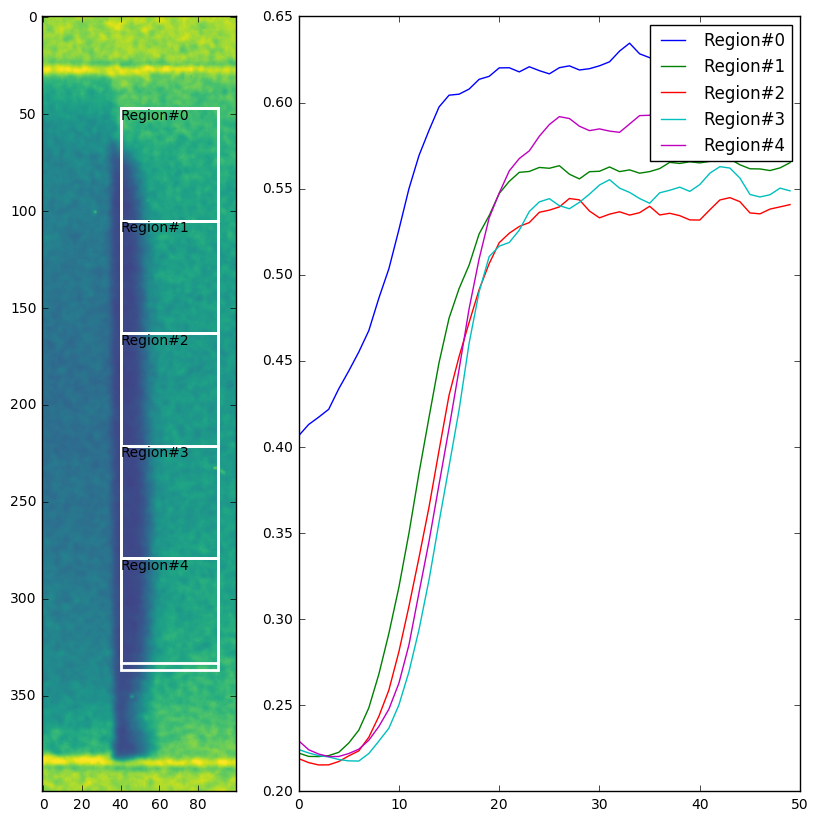

In [6]:
def plot_images(image_index, x_left, y_top, width, height, number_sub_region, size_of_plot):
    
    fig = plt.figure(figsize=(size_of_plot, size_of_plot))
    ax_img = plt.subplot2grid((1,3), (0,0))
    ax_img.imshow(data_array[image_index], cmap='viridis', vmin=0, vmax=1)

    _rectangle = patches.Rectangle((x_left, y_top),
                                  width,
                                  height,
                                  edgecolor = 'white',
                                  linewidth = 2,
                                  fill = False)
    ax_img.add_patch(_rectangle)
    
    ax_profile = plt.subplot2grid((1,3), (0,1), colspan=2)
    _dict = get_array_of_profiles(data=data_array[image_index],
                                              number_sub_region = number_sub_region,
                                              x_left = x_left,
                                              y_top = y_top,
                                              width = width,
                                              height = height)
    array_of_profiles = _dict['data']
    array_of_bins_height = _dict['bins']
    
    for _index, _bins in enumerate(array_of_bins_height):
        _y_top = _bins[0]
        _height = _bins[1]-_bins[0]
        _text = "Region#{}".format(_index)
        _rectangle = patches.Rectangle((x_left, _y_top),
                                  width,
                                  _height,
                                  edgecolor = 'white',
                                  linewidth = 2,
                                  fill = False)
        ax_img.add_patch(_rectangle)
        ax_img.text(x_left, _y_top, _text, va='top', ha='left')
    
    for _index, _data in enumerate(array_of_profiles):
        _text = "Region#{}".format(_index)
        ax_profile.plot(_data, label=_text)
        
    ax_profile.legend()
    
    return {'x_left': x_left, 'y_top': y_top, 'width': width, 
            'height': height, 'number_sub_region': number_sub_region}
    
preview = interact(plot_images,
                  image_index = widgets.IntSlider(min=0, 
                                                max=len(data_array)-1,
                                                step=1,
                                                value=0,
                                                description='Image Index'),
                   x_left = widgets.IntSlider(min=0,
                                            max=width,
                                            step=1,
                                            value=int(_dict['x_left']),
                                            description='X Left'),
                  y_top = widgets.IntSlider(min=0,
                                           max=height,
                                           value=np.int(_dict['y_top']),
                                           step=1,
                                           description='Y Top'),
                  width = widgets.IntSlider(min=0,
                                           max=width,
                                           step=1,
                                           value=np.int(_dict['width']),
                                           description="Width"),
                  height = widgets.IntSlider(min=0,
                                            max=height,
                                            step=1,
                                            value=np.int(_dict['height']),
                                            description='Height'),
                   number_sub_region = widgets.IntSlider(min=1,
                                            max=20,
                                            step=1,
                                            value=np.int(_dict['number_sub_region']),
                                            description='Nbr sub-region'),
                  size_of_plot = widgets.IntSlider(min=5,
                                                  max=30,
                                                  value=10,
                                                  description='Size of plot'))

# Export Configuration

In [7]:
display(HTML('<span style="font-size: 20px; color:blue">EXPLANATION: a config file of the sub-region you selected \
is now saved to be used in the next notebook.</span>'))

result_preview = preview.widget.result
config_handler.save_config(key='profile_roi', value=result_preview, group=ipts_group)

dict_config = {}
dict_config['list_of_data_files'] = list_of_data_files
dict_config['profile_roi'] = result_preview

config_key = os.path.basename(data_folder)
config_handler.save_config(key=config_key, value=dict_config, group=ipts_group)

list_of_config = config_handler.load_config(key='list_of_config', group=ipts_group)
if list_of_config == '':
    list_of_config = [config_key]
else:
    list_of_config.append(config_key)
    list_of_config = set(list_of_config)
    list_of_config = list(list_of_config)
config_handler.save_config(key='list_of_config', value=list_of_config, group=ipts_group)